## Imports

In [3]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, RNN, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from ingestion import get_prediction_data, get_training_data
from eth import get_crypto_data

2023-07-17 19:10:32.433052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Extraction

In [4]:
# Load Eth data
load_dotenv()
eth_prediction = get_prediction_data(auth_token=os.environ['api_key'])
prediction_data = eth_prediction['data']

eth_train = get_training_data(auth_token=os.environ['api_key'])
train_data = eth_train['data']


In [5]:
df = pd.DataFrame(train_data)
prediction_df = pd.DataFrame(prediction_data)

In [32]:
df

,priceUsd,time,date,30_Day_Price_Forecast
2016-03-15,12.67,1458000000000,2016-03-15,8.43
2016-03-16,13.23,1458086400000,2016-03-16,8.36
2016-03-17,11.52,1458172800000,2016-03-17,8.34
2016-03-18,10.01,1458259200000,2016-03-18,9.27
2016-03-19,10.57,1458345600000,2016-03-19,9.22
...,...,...,...,...
2023-06-12,1743.19,1686528000000,2023-06-12,NaN
2023-06-13,1745.28,1686614400000,2023-06-13,NaN
2023-06-14,1729.63,1686700800000,2023-06-14,NaN
2023-06-15,1649.11,1686787200000,2023-06-15,NaN


In [108]:
# Save data as a csv file
df.to_csv('eth_data.csv')

In [5]:
df.head(-10)

,priceUsd,time,date
0,12.6667451588141313,1458000000000,2016-03-15T00:00:00.000Z
1,13.2297433153233983,1458086400000,2016-03-16T00:00:00.000Z
2,11.5231884589914778,1458172800000,2016-03-17T00:00:00.000Z
3,10.0101331519362793,1458259200000,2016-03-18T00:00:00.000Z
4,10.5683854304196001,1458345600000,2016-03-19T00:00:00.000Z
...,...,...,...
2631,1891.0288723674763130,1685664000000,2023-06-02T00:00:00.000Z
2632,1900.6522499510397829,1685750400000,2023-06-03T00:00:00.000Z
2633,1901.3326151072273861,1685836800000,2023-06-04T00:00:00.000Z
2634,1851.2790787657058775,1685923200000,2023-06-05T00:00:00.000Z


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime("%Y-%m-%d")

In [7]:
prediction_df['date'] = pd.to_datetime(prediction_df['date'])
prediction_df['date'] = prediction_df['date'].dt.strftime("%Y-%m-%d")

In [8]:
df['priceUsd'] = df['priceUsd'].astype(float)
df['priceUsd'] = df['priceUsd'].round(2)

In [9]:
prediction_df['priceUsd'] = prediction_df['priceUsd'].astype(float)
prediction_df['priceUsd'] = prediction_df['priceUsd'].round(2)

In [10]:
df = df.set_index(pd.DatetimeIndex(df['date'].values))

In [11]:
prediction_df = prediction_df.set_index(pd.DatetimeIndex(prediction_df['date'].values))

In [12]:
# Set Forecast  
future_days = 30

In [13]:
# New column for forecast price
df[str(future_days)+'_Day_Price_Forecast'] = df[['priceUsd']].shift(-future_days)

In [14]:
df[['date',str(future_days)+'_Day_Price_Forecast']]

,date,30_Day_Price_Forecast
2016-03-15,2016-03-15,8.43
2016-03-16,2016-03-16,8.36
2016-03-17,2016-03-17,8.34
2016-03-18,2016-03-18,9.27
2016-03-19,2016-03-19,9.22
...,...,...
2023-06-12,2023-06-12,NaN
2023-06-13,2023-06-13,NaN
2023-06-14,2023-06-14,NaN
2023-06-15,2023-06-15,NaN


In [15]:
# Independent dataset
X = np.array(df[['priceUsd']])
X = X[:df.shape[0] - future_days]

In [16]:
X_pred = np.array(prediction_df[['priceUsd']])

In [17]:
# Dependent dataset
y = np.array(df[str(future_days)+'_Day_Price_Forecast'])
y = y[:-future_days]

In [18]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [19]:
# Train SVR model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma= 0.00001)
svr_rbf.fit(x_train, y_train)

SVR(C=1000.0, gamma=1e-05)

In [20]:
# Predict on test samples
svr_rbf_confidence = svr_rbf.score(x_test, y_test)
print('svr_rbf accuracy:', svr_rbf_confidence)

svr_rbf accuracy: 0.9096970151359


In [21]:
svm_prediction = svr_rbf.predict(x_test)

In [35]:
prediction_df

,priceUsd,time,date
2023-06-17,1734.13,1686960000000,2023-06-17
2023-06-18,1736.90,1687046400000,2023-06-18
2023-06-19,1728.10,1687132800000,2023-06-19
2023-06-20,1745.05,1687219200000,2023-06-20
2023-06-21,1836.05,1687305600000,2023-06-21
2023-06-22,1896.39,1687392000000,2023-06-22
2023-06-23,1887.99,1687478400000,2023-06-23
2023-06-24,1888.94,1687564800000,2023-06-24
2023-06-25,1902.01,1687651200000,2023-06-25
2023-06-26,1876.42,1687737600000,2023-06-26


In [28]:
X_pred

array([[1734.13],
       [1736.9 ],
       [1728.1 ],
       [1745.05],
       [1836.05],
       [1896.39],
       [1887.99],
       [1888.94],
       [1902.01],
       [1876.42],
       [1882.13],
       [1856.97],
       [1851.31],
       [1890.38],
       [1923.05],
       [1920.81],
       [1957.73],
       [1952.77],
       [1922.58],
       [1904.61],
       [1862.84],
       [1863.94],
       [1869.85],
       [1868.81],
       [1876.74],
       [1884.46],
       [1913.22],
       [1982.11],
       [1937.07],
       [1934.23]])

In [22]:
predicted_forecast = svr_rbf.predict(X_pred)

In [23]:
predicted_forecast

array([1787.88452243, 1790.41252059, 1782.17850551, 1797.49699254,
       1842.040083  , 1861.98630228, 1857.81636216, 1858.25189713,
       1865.21388504, 1853.14632455, 1855.31279617, 1847.23733461,
       1845.78753222, 1858.92887874, 1881.07096644, 1879.06717263,
       1923.53034567, 1916.04615781, 1880.64379097, 1866.83804378,
       1848.83672722, 1849.15070099, 1850.93371261, 1850.60711103,
       1853.26131569, 1856.27185396, 1872.86186786, 1967.66518633,
       1895.54473875, 1892.3331166 ])

In [24]:
import plotly.express as px

In [29]:
prediction_df['date'] = pd.to_datetime(prediction_df['date'])

In [27]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-06-17 to 2023-07-16
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   priceUsd  30 non-null     float64
 1   time      30 non-null     int64  
 2   date      30 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 960.0+ bytes


In [30]:
prediction_df['testdate'] = prediction_df['date'] + pd.Timedelta(days=30)

In [31]:
prediction_df['testdate']

2023-06-17   2023-07-17
2023-06-18   2023-07-18
2023-06-19   2023-07-19
2023-06-20   2023-07-20
2023-06-21   2023-07-21
2023-06-22   2023-07-22
2023-06-23   2023-07-23
2023-06-24   2023-07-24
2023-06-25   2023-07-25
2023-06-26   2023-07-26
2023-06-27   2023-07-27
2023-06-28   2023-07-28
2023-06-29   2023-07-29
2023-06-30   2023-07-30
2023-07-01   2023-07-31
2023-07-02   2023-08-01
2023-07-03   2023-08-02
2023-07-04   2023-08-03
2023-07-05   2023-08-04
2023-07-06   2023-08-05
2023-07-07   2023-08-06
2023-07-08   2023-08-07
2023-07-09   2023-08-08
2023-07-10   2023-08-09
2023-07-11   2023-08-10
2023-07-12   2023-08-11
2023-07-13   2023-08-12
2023-07-14   2023-08-13
2023-07-15   2023-08-14
2023-07-16   2023-08-15
Name: testdate, dtype: datetime64[ns]

In [32]:
px.line(x=prediction_df['testdate'], y=predicted_forecast)

In [154]:
x_train.shape, y_train.shape

((2107, 1), (2107,))

In [26]:
df['date']

2016-03-15    2016-03-15
2016-03-16    2016-03-16
2016-03-17    2016-03-17
2016-03-18    2016-03-18
2016-03-19    2016-03-19
                 ...    
2023-06-12    2023-06-12
2023-06-13    2023-06-13
2023-06-14    2023-06-14
2023-06-15    2023-06-15
2023-06-16    2023-06-16
Name: date, Length: 2646, dtype: object

In [155]:
print(y_test)

[ 931.14  136.97  182.27 1492.73   94.44 1967.19  165.36 1799.83  347.15
  242.33    7.64  456.05  121.94  311.6    11.61 3439.14  148.85  295.91
  218.61   13.12  239.84 3084.05  198.96 1566.49  436.07  326.34   10.39
 1853.7   245.78 1653.84 1735.7   258.2     9.59  356.8  3116.76 1227.18
   49.67  173.41 4286.11  162.6   222.82 3804.18 1568.73  170.43   13.83
 1778.87  237.33  137.42  168.58 1486.6  1809.59 2234.59   44.02   13.1
 1896.88  742.06 1195.1   233.28   11.26 1074.93  105.25 3540.34 1571.19
  685.5    10.56 4367.04  618.35   11.   2000.47    8.53  118.57  483.64
  136.48 2124.65  268.06 2037.31   28.45   13.83  467.54  214.67  131.79
    7.88  321.12   10.15 1883.   1283.03  199.51 3258.76 4365.8   523.15
  142.42  163.03  701.98  867.55 3253.01 3253.35   13.11 1360.13   11.08
 1327.54    8.43  338.94  395.09  270.31 1281.34  122.7  4742.42    9.61
  323.45 2972.39   91.05  521.53    9.85  180.79  345.88  121.29 3773.64
  239.66 1848.77   10.47 1939.15 3339.01  177.09  29

In [165]:
z.shape, svm_prediction.shape, X.shape

((2634, 1), (527,), (2634, 1))

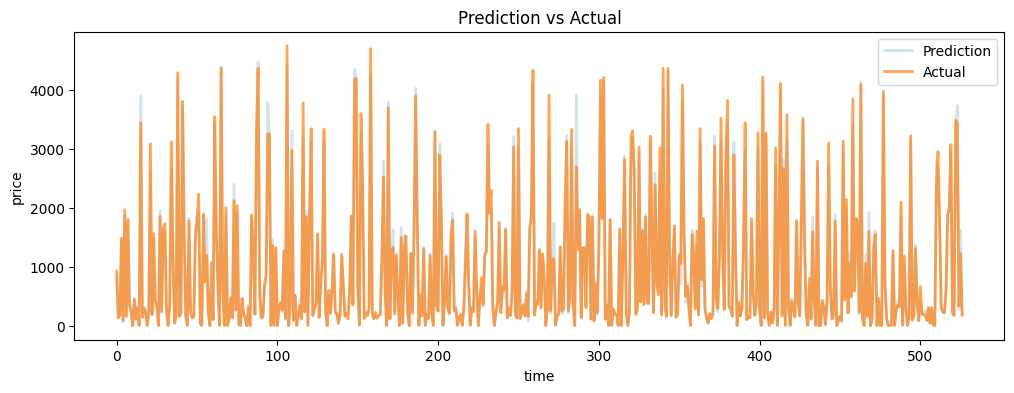

In [156]:
plt.figure(figsize=(12,4))
plt.plot(svm_prediction, label='Prediction', lw=2, alpha=0.2)
plt.plot(y_test, label='Actual', lw=2, alpha=0.7)
plt.title("Prediction vs Actual")
plt.ylabel("price")
plt.xlabel("time")
plt.legend()
plt.show()